In [1]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import os

import tensorflow_hub as hub
import tensorflow as tf

import torchaudio
import torch
from torch.utils.data import DataLoader, Dataset


df = pd.read_csv('/kaggle/input/birdclef-2023/train_metadata.csv')
AUDIO_PATH = Path('/kaggle/input/birdclef-2023/train_audio')
model = hub.load('https://kaggle.com/models/google/bird-vocalization-classifier/frameworks/TensorFlow2/variations/bird-vocalization-classifier/versions/2')
model_labels_df = pd.read_csv(hub.resolve('https://kaggle.com/models/google/bird-vocalization-classifier/frameworks/tensorFlow2/variations/bird-vocalization-classifier/versions/2') + "/assets/label.csv")

SAMPLE_RATE = 32000
WINDOW = 5*SAMPLE_RATE

In [2]:
bc2023_labels = sorted(df.primary_label.unique())
label_to_index = {v: k for k, v in enumerate(bc2023_labels)}
model_labels = {v: k for k, v in enumerate(model_labels_df.ebird2021)}
model_bc2023_indexes = [model_labels[label] if label in model_labels else -1 for label in bc2023_labels]

# Save embeddings and predictions for every 5 sec non-overlapping audio

In [3]:
# use a torch dataloader to decode audio in parallel on CPU while GPU is running
class AudioDataset(Dataset):
    def __len__(self):
        return len(df)
    def __getitem__(self, i):
        filename = df.filename[i]
        audio = torchaudio.load(AUDIO_PATH / filename)[0].numpy()[0]
        return audio, filename
dataloader = DataLoader(AudioDataset(), batch_size=1, num_workers=os.cpu_count())


# embeddings are formated like {"filename": np.array(nx1280)} 
# (where n = the number of non overlapping 5 sec chunks in the audio)
all_embeddings = {}

# predictiones formated like {"filename": np.array(nx264)} 
all_predictions = {}

with tf.device('/gpu:0'):
    for audio, filename in tqdm(dataloader):
        audio = audio[0]
        filename = filename[0]
        file_embeddings = []
        file_predictions = []
        for i in range(0, len(audio), WINDOW):
            clip = audio[i:i+WINDOW]
            if len(clip) < WINDOW:
                clip = np.concatenate([clip, np.zeros(WINDOW - len(clip))])
            result = model.infer_tf(clip[None, :])
            file_embeddings.append(result[1][0].numpy())
            prediction = np.concatenate([result[0].numpy(), -100], axis=None) # add -100 logit for unpredicted birds
            file_predictions.append(prediction[model_bc2023_indexes])
        all_embeddings[filename] = np.stack(file_embeddings)
        all_predictions[filename] = np.stack(file_predictions)

torch.save(all_embeddings, 'embeddings.pt')
torch.save(all_predictions, 'predictions.pt')

100%|██████████| 16941/16941 [25:57<00:00, 10.88it/s]


# Scores of predictions on the first 5 seconds of each recording

In [4]:
predicted_classes = torch.tensor([row[0].argmax() for row in all_predictions.values()])
actual_classes = torch.tensor([label_to_index[label] for label in df.primary_label])
correct = predicted_classes == actual_classes
accuracy = correct.float().mean()
accuracy

tensor(0.8808)

In [5]:
logits = torch.stack([torch.tensor(row[0]) for row in all_predictions.values()])
ce_loss = torch.nn.CrossEntropyLoss()(logits, actual_classes)
ce_loss

tensor(1.5971)

In [6]:
actual_probs = torch.eye(len(bc2023_labels))[actual_classes]
bce_loss = torch.nn.BCEWithLogitsLoss()(logits, actual_probs)
bce_loss

tensor(0.0094)

In [7]:
import pandas as pd
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):
    #solution = solution.drop(['row_id'], axis=1, errors='ignore')
    #submission = submission.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

In [8]:
solution = pd.DataFrame(actual_probs.numpy(), columns=bc2023_labels)
padded_cmap(
    solution=solution,
    submission=pd.DataFrame(torch.softmax(logits, 1).numpy(), columns=bc2023_labels),
)

0.9371514707509073

In [9]:
padded_cmap(
    solution=solution,
    submission=pd.DataFrame(torch.sigmoid(logits).numpy(), columns=bc2023_labels),
)

0.90117170284443

# Analysis

In [10]:
df['correct'] = correct.bool().numpy()

In [11]:
import plotly.express as px

px.histogram(
    df,
    title="Distribution of accuracy",
    x='primary_label',
    color='correct',
).update_xaxes(categoryorder="total descending").show()

# Failure examples

### EXAMPLE 1 ###
correct was eubeat1, given prob 0.02334635704755783 and ranked #15
predicted comsan, with prob 0.6918415427207947



primary_label                                                 eubeat1
secondary_labels                                                   []
type                                                  ['flight call']
latitude                                                       49.634
longitude                                                     26.2213
scientific_name                                       Merops apiaster
common_name                                        European Bee-eater
author                                                 Ruslan Mazuryk
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            3.0
url                                 https://www.xeno-canto.org/385287
filename                                         eubeat1/XC385287.ogg
correct                                                         False
Name: 6671, dtype: object

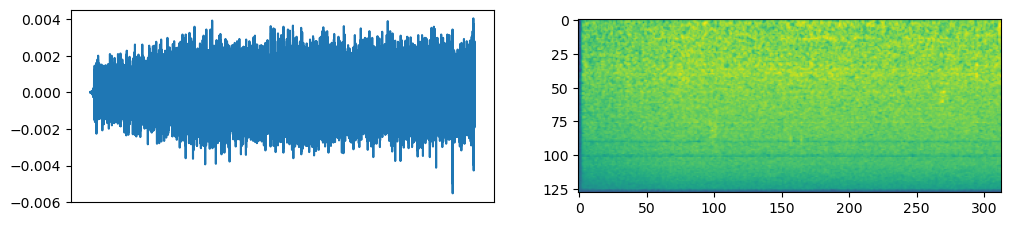

### EXAMPLE 2 ###
correct was egygoo, given prob 0.006111211609095335 and ranked #2
predicted comsan, with prob 0.006272175814956427



primary_label                                                  egygoo
secondary_labels                                                   []
type                        ['call', 'female', 'flight call', 'male']
latitude                                                      52.4099
longitude                                                     -1.4177
scientific_name                                  Alopochen aegyptiaca
common_name                                            Egyptian Goose
author                                                 Nikolay Sariev
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            4.5
url                                 https://www.xeno-canto.org/631951
filename                                          egygoo/XC631951.ogg
correct                                                         False
Name: 6392, dtype: object

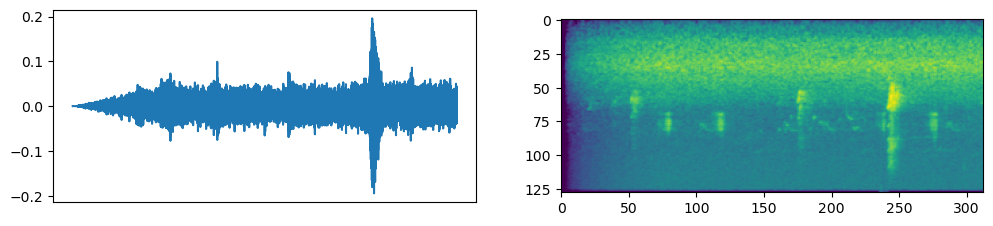

### EXAMPLE 3 ###
correct was blakit1, given prob 0.07053984701633453 and ranked #2
predicted piecro1, with prob 0.7058300375938416



primary_label                                                 blakit1
secondary_labels                                                   []
type                                                         ['call']
latitude                                                       8.4757
longitude                                                    -13.2539
scientific_name                                        Milvus migrans
common_name                                                Black Kite
author                                               Jacqueline Leigh
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            3.0
url                                 https://www.xeno-canto.org/467575
filename                                         blakit1/XC467575.ogg
correct                                                         False
Name: 1983, dtype: object

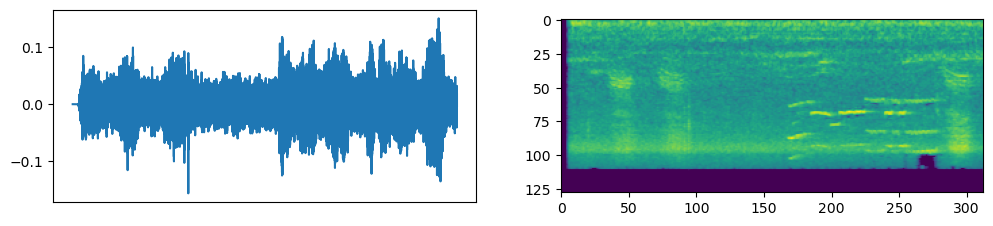

### EXAMPLE 4 ###
correct was gbesta1, given prob 1.3413918982365132e-17 and ranked #83
predicted wlwwar, with prob 2.5653914690337842e-06



primary_label                                                 gbesta1
secondary_labels                                          ['piecro1']
type                                                         ['song']
latitude                                                        8.765
longitude                                                       38.97
scientific_name                               Lamprotornis chalybaeus
common_name                               Greater Blue-eared Starling
author                                                     Rory Nefdt
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            2.5
url                                 https://www.xeno-canto.org/195013
filename                                         gbesta1/XC195013.ogg
correct                                                         False
Name: 7291, dtype: object

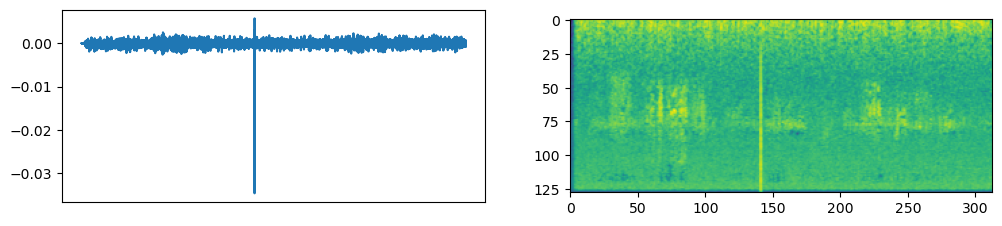

### EXAMPLE 5 ###
correct was grccra1, given prob 0.0006572792772203684 and ranked #7
predicted yertin1, with prob 0.0027986066415905952



primary_label                                                 grccra1
secondary_labels                                                   []
type                                                             ['']
latitude                                                        -14.5
longitude                                                        22.5
scientific_name                                   Balearica regulorum
common_name                                        Gray Crowned-Crane
author                                                  Derek Solomon
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            3.5
url                                     https://xeno-canto.org/737596
filename                                         grccra1/XC737596.ogg
correct                                                         False
Name: 7788, dtype: object

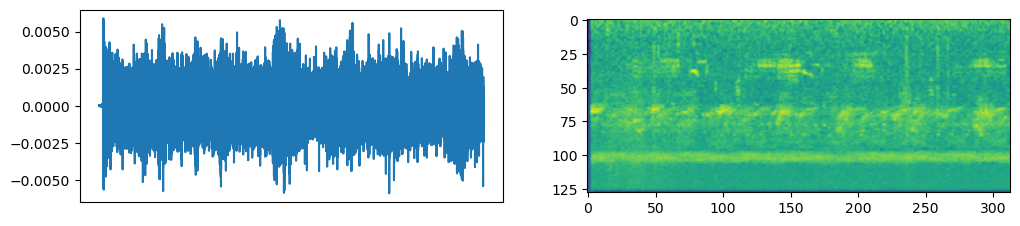

### EXAMPLE 6 ###
correct was rbsrob1, given prob 0.10791859030723572 and ranked #2
predicted gycwar3, with prob 0.1257302165031433



primary_label                                                 rbsrob1
secondary_labels                                                   []
type                                                             ['']
latitude                                                     -26.7739
longitude                                                     26.6944
scientific_name                               Cercotrichas leucophrys
common_name                                    Red-backed Scrub-Robin
author                                                    Tony Archer
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            4.5
url                                     https://xeno-canto.org/704627
filename                                         rbsrob1/XC704627.ogg
correct                                                         False
Name: 11342, dtype: object

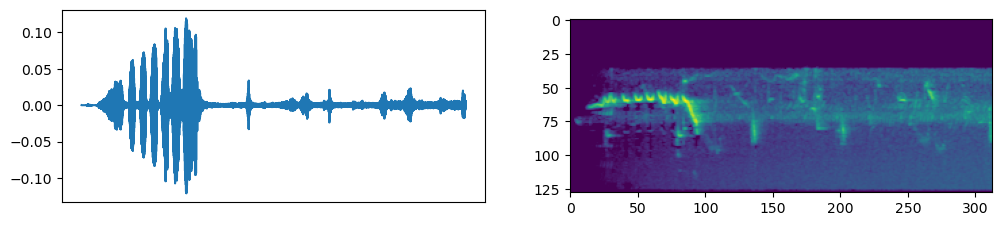

### EXAMPLE 7 ###
correct was barswa, given prob 0.0017329042311757803 and ranked #2
predicted wlwwar, with prob 0.005560311488807201



primary_label                                                  barswa
secondary_labels                                                   []
type                               ['call', 'flight call', 'highway']
latitude                                                      39.5456
longitude                                                   -119.5814
scientific_name                                       Hirundo rustica
common_name                                              Barn Swallow
author                                                   Bobby Wilcox
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            3.0
url                                 https://www.xeno-canto.org/256217
filename                                          barswa/XC256217.ogg
correct                                                         False
Name: 961, dtype: object

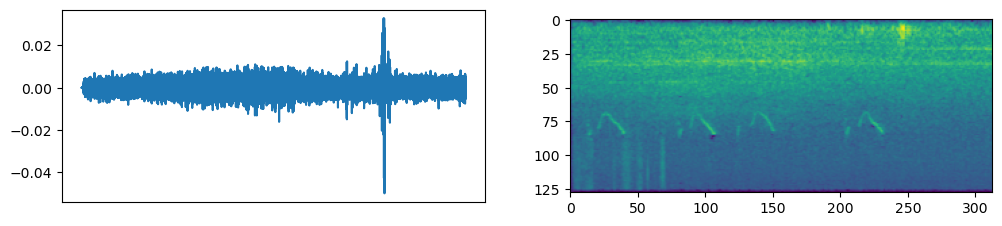

### EXAMPLE 8 ###
correct was easmog1, given prob 1.2657496029078175e-07 and ranked #207
predicted hoopoe, with prob 0.004040319938212633



primary_label                                                 easmog1
secondary_labels                                                   []
type                                                         ['call']
latitude                                                      -1.3589
longitude                                                     29.6187
scientific_name                               Arizelocichla nigriceps
common_name                                 Eastern Mountain Greenbul
author                                               Martin St-Michel
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            3.0
url                                 https://www.xeno-canto.org/235700
filename                                         easmog1/XC235700.ogg
correct                                                         False
Name: 5747, dtype: object

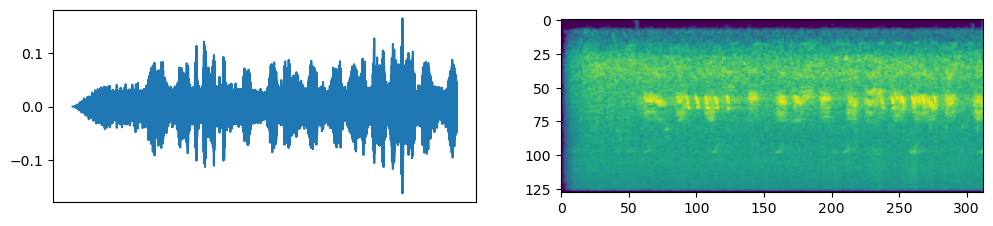

### EXAMPLE 9 ###
correct was gnbcam2, given prob 0.01749175786972046 and ranked #2
predicted thrnig1, with prob 0.021984262391924858



primary_label                                                 gnbcam2
secondary_labels                                                   []
type                                                             ['']
latitude                                                      -2.9965
longitude                                                     37.6244
scientific_name                              Camaroptera brevicaudata
common_name                                   Gray-backed Camaroptera
author                                                   isaac kilusu
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            3.0
url                                     https://xeno-canto.org/548658
filename                                         gnbcam2/XC548658.ogg
correct                                                         False
Name: 7520, dtype: object

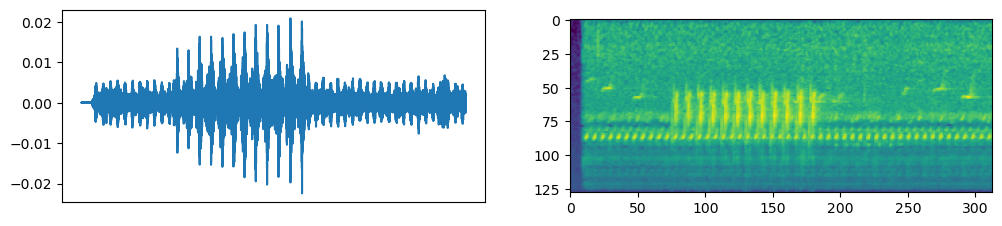

### EXAMPLE 10 ###
correct was combuz1, given prob 0.004124567843973637 and ranked #3
predicted eaywag1, with prob 0.8477436304092407



primary_label                                                 combuz1
secondary_labels                                          ['eaywag1']
type                                                         ['call']
latitude                                                      51.3672
longitude                                                      5.8406
scientific_name                                           Buteo buteo
common_name                                            Common Buzzard
author                                                     Ad Hilders
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            2.5
url                                      http://xeno-canto.org/672595
filename                                         combuz1/XC672595.ogg
correct                                                         False
Name: 4973, dtype: object

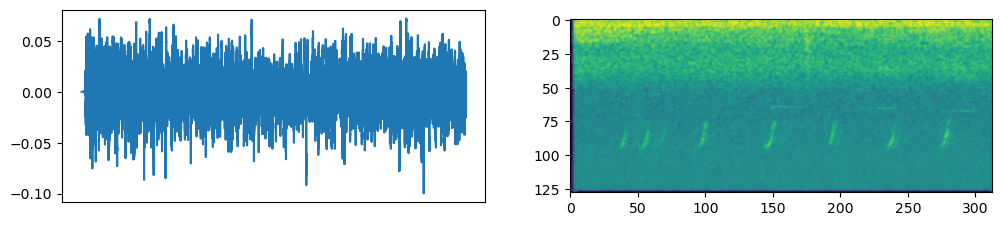

In [12]:
from IPython.display import Audio
import torchaudio
import matplotlib.pyplot as plt

compute_melspec = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_mels=128,
    n_fft=2048, 
    hop_length=512,
    f_min=0,
    f_max=SAMPLE_RATE // 2,
)

power_to_db = torchaudio.transforms.AmplitudeToDB(
    stype="power",
    top_db=80.0,
)

def show_bird(index, start=0):
    audio = torchaudio.load(AUDIO_PATH / df.filename[index], start, start+WINDOW)[0][0]
    display(df.iloc[index])
    display(Audio(audio, rate=SAMPLE_RATE))
    plt.figure(figsize=(12, 2.5))
    plt.subplot(121)
    plt.plot(audio)
    plt.gca().get_xaxis().set_visible(False)
    plt.subplot(122)
    plt.imshow(power_to_db(compute_melspec(audio)))
    plt.show()
    return 


# filter out birds that the model doesn't predict
missing_birds = set(np.array(bc2023_labels)[np.array(model_bc2023_indexes) == -1]) 
probs = torch.sigmoid(logits)

for count, i in enumerate(df[~df.correct & ~df.primary_label.isin(missing_birds)].sample(10).index):
    print('### EXAMPLE', count+1,'###')
    correct_class = df.primary_label[i]
    predicted_class_index = label_to_index[correct_class]
    predicted_prob_for_correct_label = probs[i, predicted_class_index]
    rank = 1 + sorted(probs[i], reverse=True).index(predicted_prob_for_correct_label)
    
    predicted_class_index = probs[i].argmax().item()
    predicted_clas = bc2023_labels[predicted_class_index]
    max_predicted_prob = probs[i][predicted_class_index]
    
    print(f'correct was {correct_class}, given prob {predicted_prob_for_correct_label} and ranked #{rank}')
    print(f'predicted {predicted_clas}, with prob {max_predicted_prob}')
    print()
    show_bird(i)